Source notebook: https://github.com/statscol/clip-fine-tuning/blob/main/clip-fine-tuning.ipynb

## Fine-tuning Clip on PolyHaven dataset


The following graph shows the approach, where basically we need an image an text encoder to compute representations on each source and compute similarities later on

![image.png](https://miro.medium.com/max/786/1*tg7akErlMSyCLQxrMtQIYw.png)

In [1]:
import numpy as np
import clip
import torch
from tqdm.notebook import tqdm
from pkg_resources import packaging
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from PIL import Image
from torch.utils.data.sampler import SubsetRandomSampler
print("Torch version:", torch.__version__)

Torch version: 2.0.1


## Load CLIP and VAE

In [2]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

from model_cond import VAE
vae = VAE().to(DEVICE)

to_tensor = transforms.ToTensor()

vae_transform = transforms.Compose([
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

vae.load_state_dict(torch.load("train_results/model_weights_final.pth"))

dummy input shape  torch.Size([4096])


<All keys matched successfully>

In [3]:
torch.cuda.empty_cache()
model, preprocess = clip.load("ViT-B/32", jit=False)

In [4]:
preprocess_tensor = transforms.Compose([
        preprocess.transforms[0],
        preprocess.transforms[1],
        preprocess.transforms[4]
])

def apply_vae(img, model_vae, preprocess_fn):

    img_vae = model_vae(vae_transform(img))[0]
    return preprocess_fn(img_vae).detach()

## Load Data

In [5]:
## Get labels
from pathlib import Path
import pandas as pd
labels=pd.read_json("dataset/polyhaven.json")
labels.head()

,name,tags,categories,caption
0,abandoned_bakery_1k,"[abandoned, empty, industrial, windows, bare, ...","[natural light, artificial light, urban, indoo...","[abandoned, empty, industrial, windows, bare, ..."
1,abandoned_church_1k,"[tree, autumn, church, abandoned, leaves]","[outdoor, nature, morning-afternoon, partly cl...","[tree, autumn, church, abandoned, leaves, outd..."
2,abandoned_construction_1k,"[brick, pillar, warehouse, rubble, abandoned, ...","[indoor, urban, natural light, medium contrast...","[brick, pillar, warehouse, rubble, abandoned, ..."
3,abandoned_factory_canteen_01_1k,"[hall, abandoned, fluorescent, industrial, bac...","[indoor, urban, low contrast, natural light]","[hall, abandoned, fluorescent, industrial, bac..."
4,abandoned_factory_canteen_02_1k,"[hall, abandoned, industrial, boxes, backplates]","[indoor, urban, natural light, medium contrast]","[hall, abandoned, industrial, boxes, backplate..."


In [6]:
train = labels
train.sort_values(by="name", ascending=True, inplace=True)
print(train.shape)

(477, 4)


In [7]:
#using datasets.ImageFolder makes loading images and preprocessing easier
image_folder = datasets.ImageFolder("dataset/polyhaven_clip",transform=to_tensor) #before transform=preprocess

In [8]:
## Create datasets
class PolyHaven(Dataset):
    def __init__(self,captions,image_tensors):
        self.captions=captions
        self.images=image_tensors
        
    def __getitem__(self,idx):
        image_idx,_=self.images[idx]
        caption_idx=self.captions[idx]
        return {'image':image_idx,'caption': " ".join(caption_idx)}
        
    def __len__(self):
        return len(self.captions)
    
dataset = PolyHaven(train.caption.values.tolist(), image_folder)
len(dataset)

477

In [9]:
## create dataloaders
BATCH_SIZE  =  8
TEST_SPLIT  = .3
RANDOM_SEED = 42

dataset_size = train.shape[0]
indices = list(range(dataset_size))
split = int(np.floor(TEST_SPLIT * dataset_size))
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

tr_dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
ts_dl = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler)

In [10]:
import torch.nn as nn
import torch.optim as optim

N_EPOCHS = 64
loss_img = nn.CrossEntropyLoss()
loss_caption = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(tr_dl)*N_EPOCHS)

## Training code

In [11]:
DEVICE="cuda:0" if torch.cuda.is_available() else "cpu"

vae.eval()
vae.requires_grad_(False)

model.to(DEVICE)

## to avoid problems with mixed precision, taken from here https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model): 
    for p in model.parameters(): 
        p.data = p.data.float() 
        p.grad.data = p.grad.data.float()


def validate(test_dl, use_vae=False):
    model.eval()
    test_loss=0.0
    for data in tqdm(test_dl,desc="Evaluating in validation set"):
        if use_vae == True:
            img_batch=apply_vae(data['image'].to(DEVICE), vae, preprocess_tensor)
        else: 
            img_batch=preprocess_tensor(data['image'].to(DEVICE))        
        captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
        with torch.no_grad():
            logits_image, logits_caption = model(img_batch, captions_batch)
        labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
        total_loss = (loss_img(logits_image,labels) + loss_caption(logits_caption,labels))/2
        test_loss+=total_loss.item()
    
    test_total_loss=test_loss/len(test_dl)
    print(f"Validation Loss {test_total_loss:.3f}")
    return test_total_loss


def train_model(n_epochs,train_dataloader,checkpoint_path:str="./clip_checkpoints", use_vae=False, model_name="default"):
    if not os.path.isdir(checkpoint_path):
        os.makedirs(checkpoint_path)
        
    print(f"Using {DEVICE} for training")
    best_score=9999999
    history={'train_loss':[],'val_loss':[]}
    for epoch in tqdm(range(n_epochs)):
        total_steps=0
        train_loss=0.0
        model.train()
        for step,data in enumerate(train_dataloader,1):
            
            optimizer.zero_grad()
            if use_vae == True:
                img_batch=apply_vae(data['image'].to(DEVICE), vae, preprocess_tensor)
            else: 
                img_batch=preprocess_tensor(data['image'].to(DEVICE))

            captions_batch=clip.tokenize(data['caption'],truncate=True).to(DEVICE)
            with torch.cuda.amp.autocast():
                logits_image, logits_caption = model(img_batch, captions_batch)
            labels = torch.arange(len(img_batch)).to(DEVICE)  ## we are interested on predicting the right caption which is the caption position of every image
            img_loss=loss_img(logits_image,labels)
            caption_loss=loss_caption(logits_caption,labels)
            total_loss = (img_loss+caption_loss)/2
            total_loss.backward()
            train_loss+=total_loss.item()
            convert_models_to_fp32(model)
            optimizer.step()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            total_steps+=1
            scheduler.step() ##per step scheduler
            if step%100==0:
                print(f"Epoch {epoch} step loss:{train_loss/total_steps}")
                print(f"Lr at step {step}: {optimizer.param_groups[0]['lr']:.5f}")
            
        history['train_loss'].append(train_loss/len(train_dataloader))
        val_metrics=validate(ts_dl, use_vae=use_vae)
        history['val_loss'].append(val_metrics)

        if val_metrics<best_score:
            print("Better score reached, saving checkpoint...")
            if os.path.exists(Path(checkpoint_path)/"clip_finetuned_{}.pt".format(model_name)):
                os.remove(Path(checkpoint_path)/"clip_finetuned_{}.pt".format(model_name))
            best_score=val_metrics
            torch.save(model.state_dict(), Path(checkpoint_path)/"clip_finetuned_{}.pt".format(model_name))
            
    return history
            


## Train on the PolyHaven Dataset

In [12]:
USE_VAE = False
MODEL_NAME = "polyhaven"
results=train_model(N_EPOCHS,tr_dl, use_vae=False, model_name=MODEL_NAME)

Using cuda:0 for training


  0%|          | 0/64 [00:00<?, ?it/s]

/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/c

Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.529
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.430
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.455


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.430


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.440


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.488


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.375
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.357
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.358


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.290
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.425


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.627


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.422


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.434


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.353


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.615


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.472


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.363


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.313


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.293


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.291


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.219
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.295


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.398


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.316


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.453


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.302


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.359


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.341


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.261


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.252


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.291


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.382


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.436


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.344


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.287


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.325


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.399


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.319


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.337


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.275


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.206
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.242


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.237


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.256


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.358


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.291


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.280


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.269


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.340


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.406


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.355


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.242


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.251


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.275


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.286


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.305


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.291


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.241


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.221


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.263


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.220


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.302


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.269


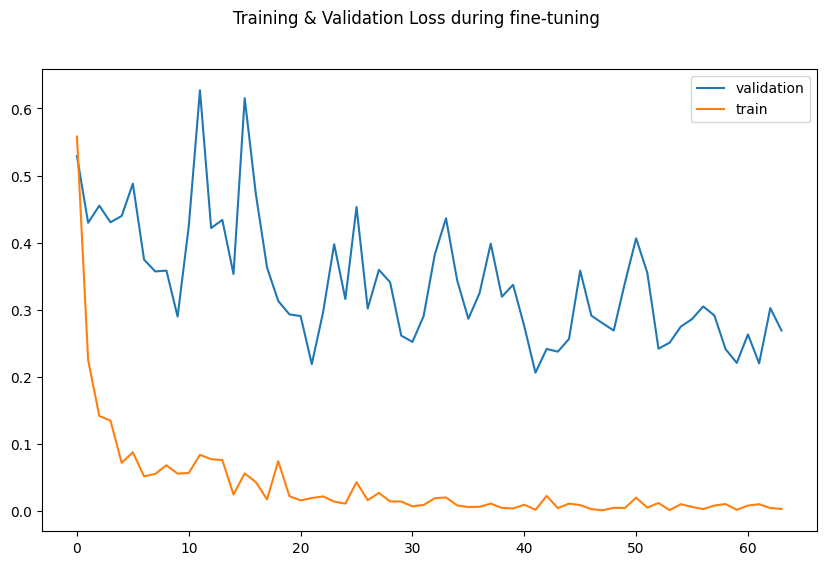

In [13]:
f,ax=plt.subplots(figsize=(10,6))
plt.plot(results['val_loss'],label="validation")
plt.plot(results['train_loss'],label="train")
plt.legend()
plt.suptitle("Training & Validation Loss during fine-tuning");

## Train on the VAE's output

In [12]:
USE_VAE = True
MODEL_NAME = "vae"
results=train_model(N_EPOCHS,tr_dl, use_vae=USE_VAE, model_name=MODEL_NAME)

Using cuda:0 for training


  0%|          | 0/64 [00:00<?, ?it/s]

/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
/home/antonio/miniconda3/envs/nlp-env/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights

Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.124
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.942
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.719
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.840


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.885


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.847


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.915


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.952


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.935


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.025


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.883


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.883


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.830


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.844


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.876


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.709
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.995


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.135


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.221


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.029


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.783


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.777


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.857


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.761


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.803


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.993


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.333


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.983


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.037


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.919


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.851


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.925


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.993


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.990


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.937


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.853


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.746


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.906


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.919


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.808


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.874


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.711


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.746


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.785


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.973


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.918


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.868


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.809


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.849


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.950


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.825


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.964


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.005


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.913


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.886


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.907


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.942


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 1.082


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.748


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.643
Better score reached, saving checkpoint...


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.913


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.745


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.792


Evaluating in validation set:   0%|          | 0/18 [00:00<?, ?it/s]

Validation Loss 0.923


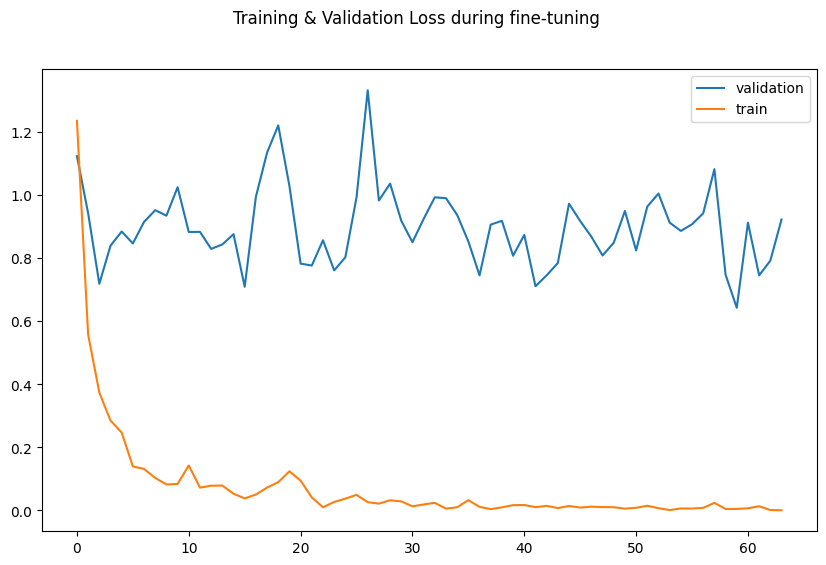

In [13]:
f,ax=plt.subplots(figsize=(10,6))
plt.plot(results['val_loss'],label="validation")
plt.plot(results['train_loss'],label="train")
plt.legend()
plt.suptitle("Training & Validation Loss during fine-tuning");